# Import Libraries

In [83]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob as gb
import numpy as np 
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import InceptionV3,MobileNetV2,DenseNet201

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, f1_score,precision_score, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix


In [45]:
# Ayarlar
epochs=10
batch_size=32
included_fish_species=['Hourse Mackerel','Red Mullet','Shrimp']
number_of_fish_species = len(included_fish_species)

# Read Dataset

In [46]:
fish_path=r'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

In [47]:
all_path=[] # Her görüntünün tam yolunu eklemek için
for img_path in os.listdir(fish_path): 
    if img_path in included_fish_species :
        all_data=gb.glob(pathname=fish_path+'/'+img_path+'/'+img_path+'/*.*')
        print(' found {} in {} '.format(len(all_data),img_path))
        all_path.extend(all_data)
    else:
        continue

 found 1000 in Hourse Mackerel 
 found 1000 in Red Mullet 
 found 1000 in Shrimp 


In [48]:
images_df=pd.DataFrame({'Filepath':all_path})
images_df['Label']=images_df['Filepath'].apply(lambda x :x.split('/')[-2])
pd.options.display.max_colwidth = 100

images_df = images_df.sample(frac=1).reset_index(drop = True)
images_df

,Filepath,Label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00962.png,Shrimp
1,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00366.png,Shrimp
3,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00689.png,Red Mullet
4,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
...,...,...
2995,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
2996,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00973.png,Shrimp
2997,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
2998,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00537.png,Red Mullet


In [87]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  3000 non-null   object
 1   Label     3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


# Exploratory Data Analysis

DataFrame is create with 2 colmuns,

path will have the paths to impage in the folder
Label will have the corresponding label name for the image

In [106]:
images_df['Label'].value_counts()

Label
Hourse Mackerel    1000
Red Mullet         1000
Shrimp             1000
Name: count, dtype: int64

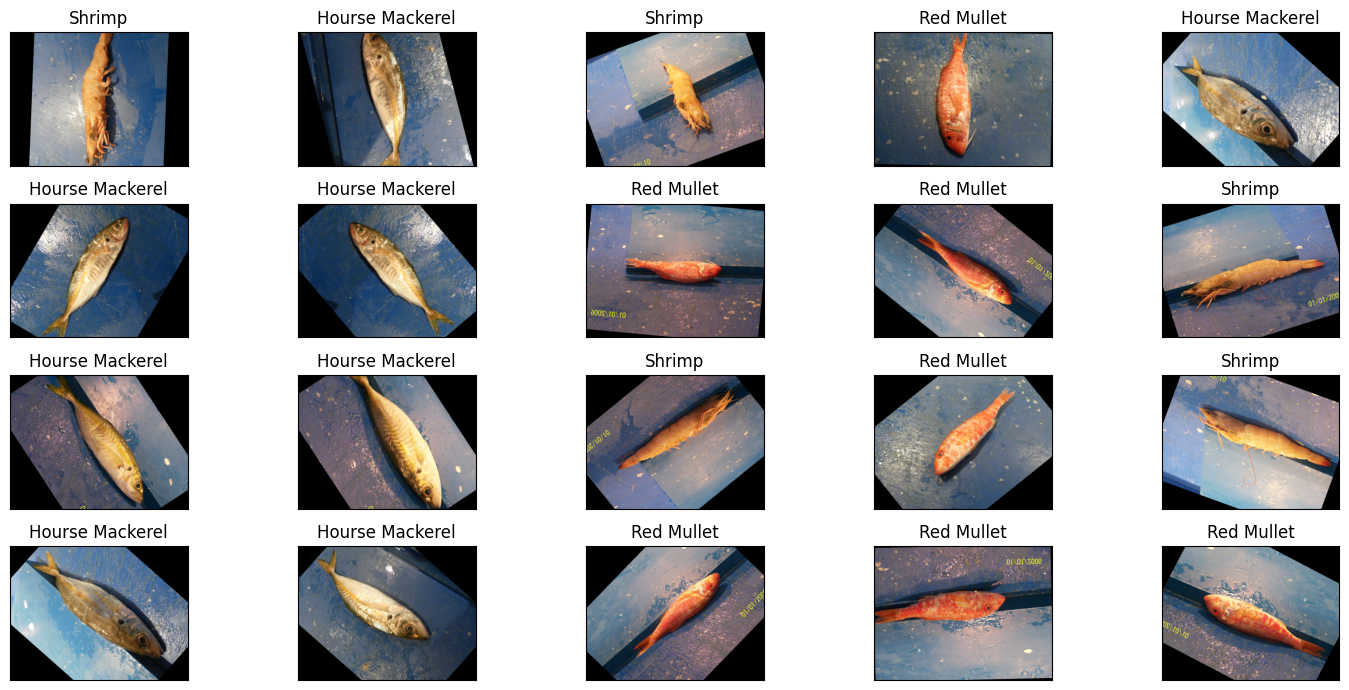

In [60]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_df.Filepath[i]))
    ax.set_title(images_df.Label[i])
plt.tight_layout()
plt.show()

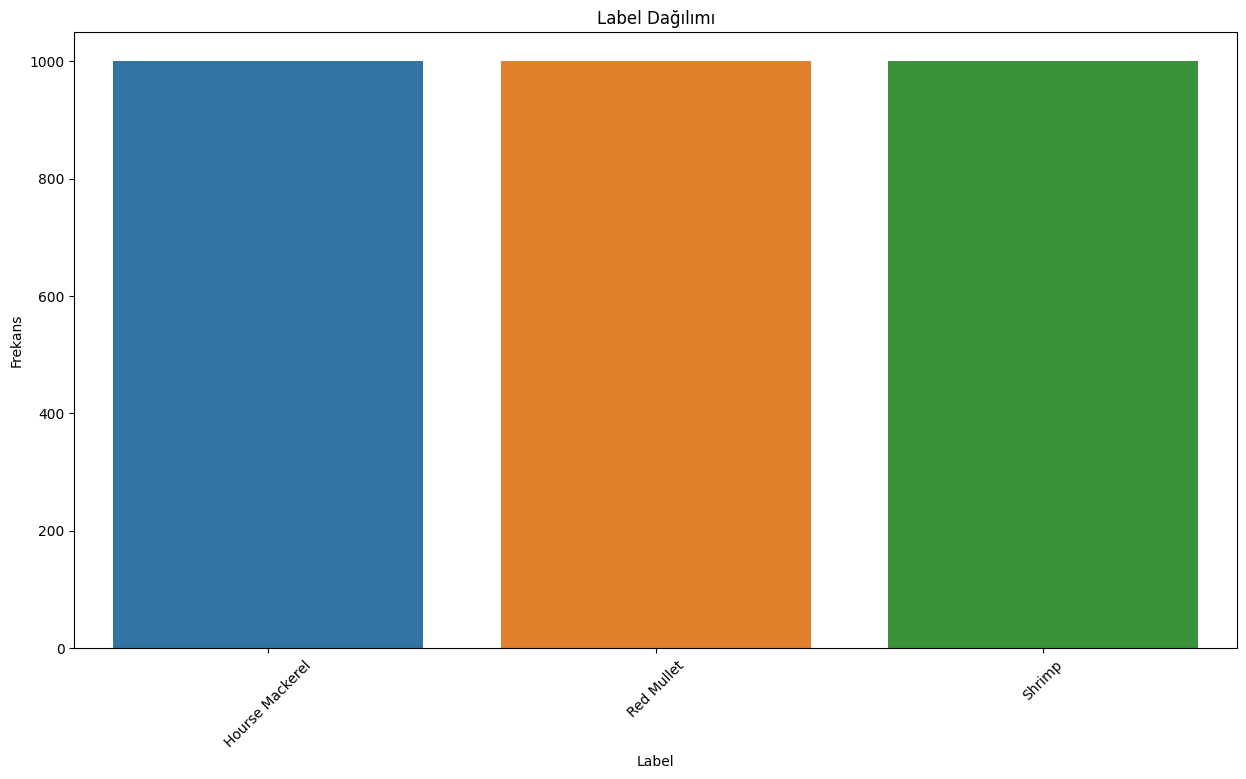

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# DataFrame'inizi kontrol ettiğinizden emin olun
fig = plt.figure(figsize=(15, 8))
sns.countplot(x='Label', data=images_df)  # Burada x ekseninde 'Label' kullanılıyor
plt.title('Label Dağılımı')
plt.xlabel('Label')
plt.ylabel('Frekans')
plt.xticks(rotation=45)  # X eksenindeki label'ları döndür
plt.show()


# Split the data

In [108]:
# split the data into training and validation set


from sklearn.model_selection import train_test_split 

x_train, x_test = train_test_split(images_df, test_size=0.3, random_state=42)
x_train, x_val = train_test_split(x_train, test_size =0.3, random_state=42)

In [109]:
print("The shape of training data", x_train.shape)
print("The shape of validation data", x_val.shape)
print("The shape of test data", x_test.shape)

The shape of training data (1470, 2)
The shape of validation data (630, 2)
The shape of test data (900, 2)


# # # Model creation

In [117]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim verisi için generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,
    x_col='Filepath',  # Resim yolunun bulunduğu sütun
    y_col='Label',     # Etiketlerin bulunduğu sütun
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=128
)

# Doğrulama verisi için generator
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_val,
    x_col='Filepath',  # Resim yolunun bulunduğu sütun
    y_col='Label',     # Etiketlerin bulunduğu sütun
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=64
)

# Test verisi için generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=x_test,
    x_col='Filepath',  # Resim yolunun bulunduğu sütun
    y_col='Label',     # Etiketlerin bulunduğu sütun
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=64
)




Found 1470 validated image filenames belonging to 3 classes.
Found 630 validated image filenames belonging to 3 classes.
Found 900 validated image filenames belonging to 3 classes.


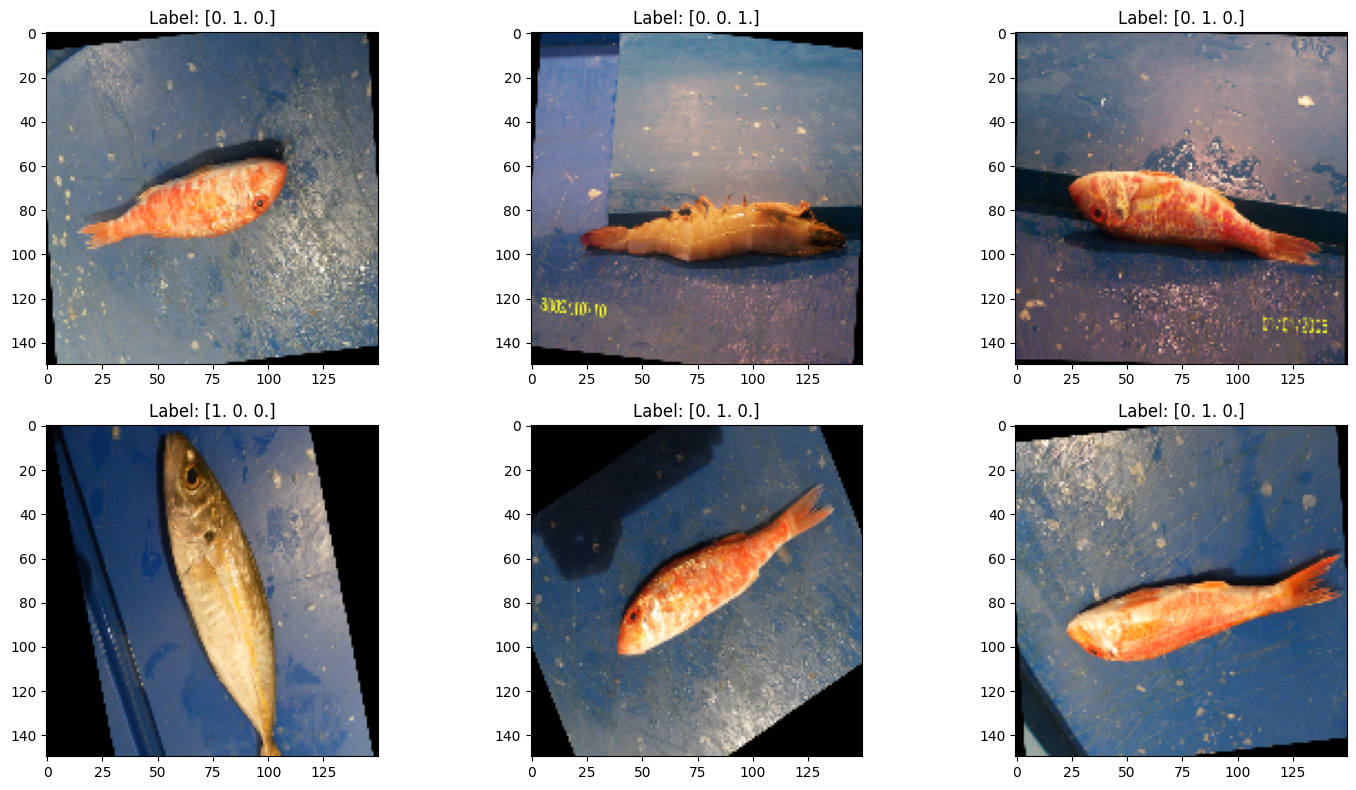

In [126]:
import matplotlib.pyplot as plt

# Resimleri ve etiketleri çizmek için 2x3'lik bir grafik oluştur
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

# 6 resim görüntüle
for j, (img, Label) in zip(range(6), test_generator):  # for döngüsünde direkt olarak kullanabilirsiniz
    ax[j].imshow(img[0])  # İlk resmi göster
    ax[j].set_title(f"Label: {Label[0]}")  # Etiketi ayarlayın

plt.tight_layout()  # Grafik düzenini iyileştirin
plt.show()  # Grafiği göster



In [129]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                          input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
    
])

In [130]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,476,553 (13.26 MB)

 Trainable params: 3,476,553 (13.26 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [133]:
from keras.layers import Dense

model.add(Dense(3, activation='softmax'))  # 3 sınıf için softmax
